# Problem Statement
You are given two datasets containing information of employees of a company:

Employee Data: Contains information about employees encoded in a JSON string.

Department Data: Contains information about departments of the company.

Your task is to analyze the data using PySpark and solve specific analysis tasks:

In [1]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Mid-term Exam: Jose Cota") \
    .master("spark://843542683a54:7077") \
    .config("spark.ui.port","4040") \
    .getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/14 13:49:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Tasks
1. Read the Data (10 points):
- Load the employees.csv and departments.csv files into PySpark DataFrames.

In [13]:
from team_name.spark_utils import SparkUtils
employees_schema = SparkUtils.generate_schema([("employee_id", "string"), ("employee_info", "string")])

employees_df = spark.read \
                .schema(employees_schema) \
                .option("header", "true") \
                .csv("/home/jovyan/notebooks/data/exam_P2025_ESI3914B/employees.csv")

employees_df.printSchema()

employees_df.show(5, truncate=False)

root
 |-- employee_id: string (nullable = true)
 |-- employee_info: string (nullable = true)

+-----------+-------------------------------------------------------------------------------------------+
|employee_id|employee_info                                                                              |
+-----------+-------------------------------------------------------------------------------------------+
|1          |{'name': 'Caitlyn', 'department_id': 103, 'salary': 115959.78, 'hire_date': '2002-06-10'}  |
|2          |{'name': 'Rachel', 'department_id': 104, 'salary': 100820.16, 'hire_date': '2009-07-01'}   |
|3          |{'name': 'Carrie', 'department_id': 105, 'salary': 114421.44, 'hire_date': '1998-12-10'}   |
|4          |{'name': 'Renee', 'department_id': 104, 'salary': 54688.13, 'hire_date': '1995-03-17'}     |
|5          |{'name': 'Gabriella', 'department_id': 109, 'salary': 106267.03, 'hire_date': '1995-02-09'}|
+-----------+---------------------------------------------

In [4]:
from team_name.spark_utils import SparkUtils
departments_schema = SparkUtils.generate_schema([("department_id", "string"), ("department_name", "string"), ("location", "string")])

departments_df = spark.read \
                .schema(departments_schema) \
                .option("header", "true") \
                .csv("/home/jovyan/notebooks/data/exam_P2025_ESI3914B/departments.csv")

departments_df.printSchema()

departments_df.show(5, truncate=False)

root
 |-- department_id: string (nullable = true)
 |-- department_name: string (nullable = true)
 |-- location: string (nullable = true)

+-------------+----------------------+---------+
|department_id|department_name       |location |
+-------------+----------------------+---------+
|101          |Human Resources       |San Diego|
|102          |Finance and Accounting|New York |
|103          |Sales and Marketing   |Chicago  |
|104          |Data Engineering      |Zapopan  |
|105          |Data Science          |Seattle  |
+-------------+----------------------+---------+
only showing top 5 rows



2. Extract the employee info from the JSON column (20 points):
- Extract the following the columns: name (string), department_id (integer), salary (double), and hire_date (date) from the employee_info column

In [37]:
from pyspark.sql.functions import get_json_object, col, when, avg
from pyspark.sql.types import IntegerType, DoubleType, DateType

employees_df = (
    employees_df
    .withColumn("name", get_json_object(employees_df.employee_info, "$.name"))
    .withColumn("department_id", get_json_object(employees_df.employee_info, "$.department_id").cast(IntegerType()))  # Cast to Integer
    .withColumn("salary", get_json_object(employees_df.employee_info, "$.salary").cast(DoubleType()))  # Cast to Double
    .withColumn("hire_date", get_json_object(employees_df.employee_info, "$.hire_date").cast(DateType()))  # Cast to Date
)

employees_df.show(truncate=False)

+-----------+-------------------------------------------------------------------------------------------+---------+-------------+---------+----------+
|employee_id|employee_info                                                                              |name     |department_id|salary   |hire_date |
+-----------+-------------------------------------------------------------------------------------------+---------+-------------+---------+----------+
|1          |{'name': 'Caitlyn', 'department_id': 103, 'salary': 115959.78, 'hire_date': '2002-06-10'}  |Caitlyn  |103          |115959.78|2002-06-10|
|2          |{'name': 'Rachel', 'department_id': 104, 'salary': 100820.16, 'hire_date': '2009-07-01'}   |Rachel   |104          |100820.16|2009-07-01|
|3          |{'name': 'Carrie', 'department_id': 105, 'salary': 114421.44, 'hire_date': '1998-12-10'}   |Carrie   |105          |114421.44|1998-12-10|
|4          |{'name': 'Renee', 'department_id': 104, 'salary': 54688.13, 'hire_date': '1995-03

3. Join Operations (10 points):

In [38]:
detailed_df = employees_df.join(departments_df, "department_id", "left")
detailed_df.show(truncate=False)

+-------------+-----------+-------------------------------------------------------------------------------------------+---------+---------+----------+-------------------------------------------+-------------+
|department_id|employee_id|employee_info                                                                              |name     |salary   |hire_date |department_name                            |location     |
+-------------+-----------+-------------------------------------------------------------------------------------------+---------+---------+----------+-------------------------------------------+-------------+
|103          |1          |{'name': 'Caitlyn', 'department_id': 103, 'salary': 115959.78, 'hire_date': '2002-06-10'}  |Caitlyn  |115959.78|2002-06-10|Sales and Marketing                        |Chicago      |
|104          |2          |{'name': 'Rachel', 'department_id': 104, 'salary': 100820.16, 'hire_date': '2009-07-01'}   |Rachel   |100820.16|2009-07-01|Data Engineeri

1. Transformations (Using when()) (10 points):

Add a new column salary_category to the enriched employee DataFrame:

If salary is greater than or equal to 55000, set salary_category to "High".

Otherwise, set salary_category to "Low".

In [39]:
# Agregar columna salary_category
df_salaries_cat = detailed_df.withColumn(
    "salary_category",
    when(col("salary") >= 55000, "High").otherwise("Low")
)

df_salaries_cat.show(truncate=False)

+-------------+-----------+-------------------------------------------------------------------------------------------+---------+---------+----------+-------------------------------------------+-------------+---------------+
|department_id|employee_id|employee_info                                                                              |name     |salary   |hire_date |department_name                            |location     |salary_category|
+-------------+-----------+-------------------------------------------------------------------------------------------+---------+---------+----------+-------------------------------------------+-------------+---------------+
|103          |1          |{'name': 'Caitlyn', 'department_id': 103, 'salary': 115959.78, 'hire_date': '2002-06-10'}  |Caitlyn  |115959.78|2002-06-10|Sales and Marketing                        |Chicago      |High           |
|104          |2          |{'name': 'Rachel', 'department_id': 104, 'salary': 100820.16, 'hire_date'

5. Filter and Group (20 points):

In [40]:
high_salary_df = df_salaries_cat.filter(col("salary_category") == "High")
low_salary_df = df_salaries_cat.filter(col("salary_category") == "Low")

In [42]:

df_avg_salary_high = high_salary_df.groupBy("department_name").agg(avg("salary").alias("avg_salary"))
df_avg_salary_low = low_salary_df.groupBy("department_name").agg(avg("salary").alias("avg_salary"))

print("Avg salary for high salary:")
df_avg_salary_high.show()
print("Avg salary for low salary:")
df_avg_salary_low.show()

Avg salary for high salary:
+--------------------+------------------+
|     department_name|        avg_salary|
+--------------------+------------------+
|Corporate Strateg...|102741.38324414717|
| Sales and Marketing|100839.65275449108|
|    Data Engineering|101626.29492163012|
|Research and Deve...|  98714.3003086419|
|Finance and Accou...|100731.07877887784|
|    Customer Service|101585.01600000002|
|               Legal|  99366.3129102167|
|        Data Science|101903.63710344829|
|          Operations|100169.65621722837|
|     Human Resources|104999.43191489363|
+--------------------+------------------+

Avg salary for low salary:
+--------------------+------------------+
|     department_name|        avg_salary|
+--------------------+------------------+
|Corporate Strateg...|41590.741833333326|
| Sales and Marketing| 41150.40277777778|
|    Data Engineering| 41358.50794117647|
|Finance and Accou...|42740.952888888874|
|Research and Deve...| 41426.43521126761|
|    Customer Servic

6. Sort (10 points):

In [46]:
top_high_df = high_salary_df.orderBy(col("salary").desc()).limit(5)
top_low_df = low_salary_df.orderBy(col("salary").desc()).limit(5)

top_high_df.show()
top_low_df.show()


+-------------+-----------+--------------------+---------+---------+----------+--------------------+-----------+---------------+
|department_id|employee_id|       employee_info|     name|   salary| hire_date|     department_name|   location|salary_category|
+-------------+-----------+--------------------+---------+---------+----------+--------------------+-----------+---------------+
|          101|       1778|{'name': 'Gabriel...|Gabriella|149989.73|2018-09-14|     Human Resources|  San Diego|           High|
|          101|       3621|{'name': 'Katheri...|Katherine| 149979.3|2017-07-26|     Human Resources|  San Diego|           High|
|          110|        346|{'name': 'Ryan', ...|     Ryan| 149963.1|1990-07-03|Corporate Strateg...|Los Angeles|           High|
|          107|       3807|{'name': 'Caitlyn...|  Caitlyn|149956.54|2000-07-27|               Legal|    Chicago|           High|
|          107|       3050|{'name': 'Mark', ...|     Mark|149915.56|2007-11-06|               Leg

7. Find the number of employees with more years in the company (15 points)

In [ ]:
from pyspark.sql.functions import year, current_date

years_df = detailed_df.withColumn("years_in_company", year(current_date()) - year(col("hire_date")))
years_df = years_df.orderBy(col("years_in_company").desc())

years_df.show(5)

+-------------+-----------+--------------------+------+---------+----------+-------------------+--------+----------------+
|department_id|employee_id|       employee_info|  name|   salary| hire_date|    department_name|location|years_in_company|
+-------------+-----------+--------------------+------+---------+----------+-------------------+--------+----------------+
|          103|        159|{'name': 'Sarah',...| Sarah| 53202.89|1988-04-14|Sales and Marketing| Chicago|              37|
|          107|        336|{'name': 'Brandy'...|Brandy|124565.98|1988-03-17|              Legal| Chicago|              37|
|          103|        182|{'name': 'Mark', ...|  Mark|122033.27|1988-11-20|Sales and Marketing| Chicago|              37|
|          107|        120|{'name': 'Megan',...| Megan| 56472.42|1988-04-03|              Legal| Chicago|              37|
|          106|        200|{'name': 'Luke', ...|  Luke| 56775.62|1988-07-12|         Operations|  London|              37|
+-------------+-

In [59]:
max_years = years_df.agg({"years_in_company": "max"}).collect()[0][0]

top_employees_df = years_df.filter(col("years_in_company") == max_years)

top_employees_count = top_employees_df.count()

print(f"Hay {top_employees_count} empleados con {max_years} de años en la empresa")

Hay 88 empleados con 37 de años en la empresa


8. Display the  Spark Plan (5 points):

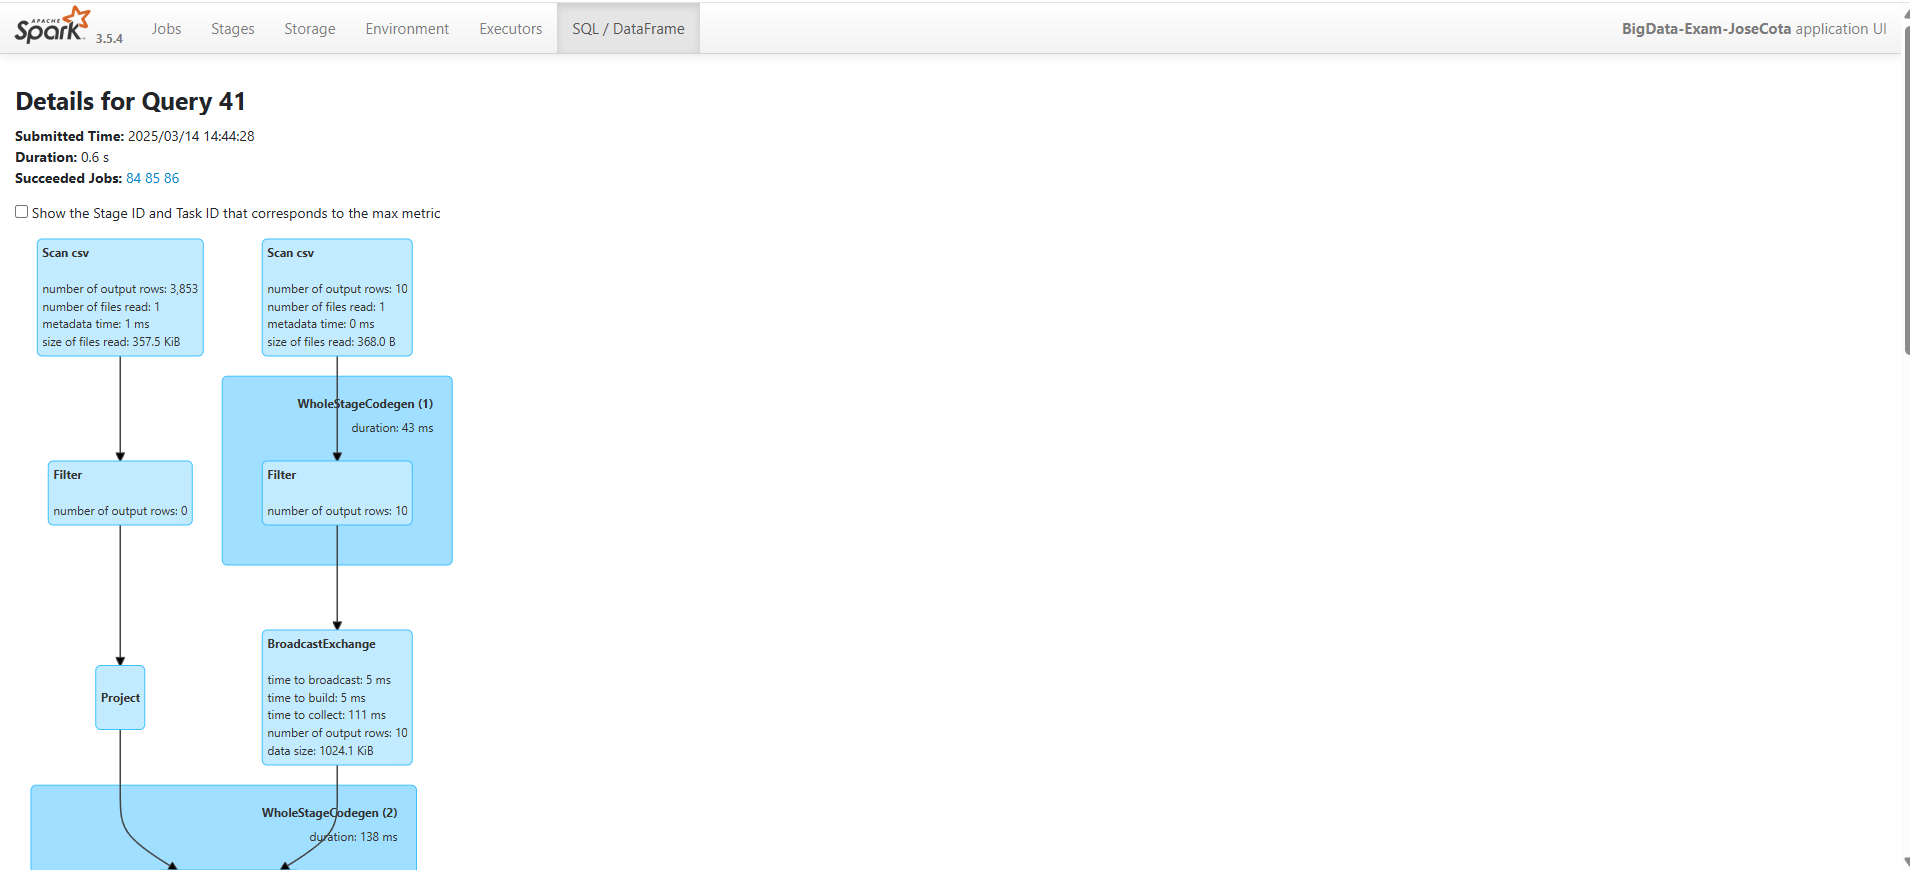